# Right Whale Detection using the Kaggle Dataset

In [1]:
import os
import glob
import pathlib
import fnmatch
import natsort 

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import regularizers
from IPython import display

AUTOTUNE = tf.data.experimental.AUTOTUNE

All the functions are in the functions.py file and imported here

In [2]:
%load_ext autoreload
%autoreload 1
%aimport functions 
#this loads the functions.py python script to use with this notebook for easier visualisation

In [3]:
TRAIN_dir = './data/train'
main_dir = './data/train/'

In [4]:
labels, filenames, num_samples = functions.data_info(TRAIN_dir, main_dir)

No Right Whale Call Audio Sample: 22973
Right Whale Call Audio Sample:    7027
Sample Labels: ['No_Right_Whale' 'Right_Whale']
Number of total examples:         30000
Example file tensor: tf.Tensor(b'.\\data\\train\\Right_Whale\\train4730.wav', shape=(), dtype=string)


Unforunately due to there being no labels on the test set folder the train set is used exclusivley, but split to create a test set.

In [5]:
train_files, val_files, test_files = functions.test_train_split(num_samples, filenames)

Training set size   24000
Validation set size  3000
Test set size        3000


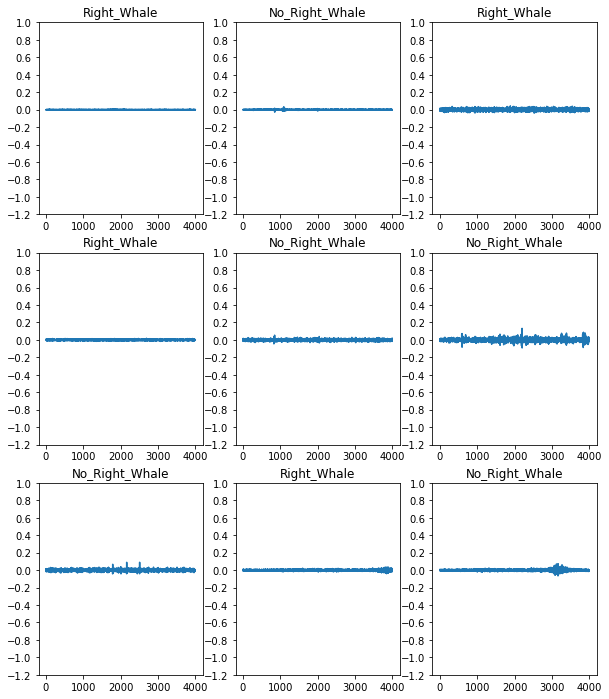

In [6]:
waveform_ds = functions.create_waveform(train_files)
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

Comparing waveforms to labels doesn't seem to show any correlation to the human eye at all! It is very difficult to see any obvious spikes or troughs to indicate a call from a whale

In [7]:
label, spectrogram = functions.audio_playback(waveform_ds)

Label: Right_Whale
Waveform shape: (4000,)
Spectrogram shape: (124, 129)
Audio playback


Here is an audio exerpt of an example waveform.

The waveforms are then converted to a spectrogram using Short Time Fourier Transform. This is done to convert the waveforms to show frequency change over time instead. It is easier to see differences in pitch in this layout, which is very valuable to differentiate between whether there is a whale call or not. This same method is applied to speech recognition.

C:\Users\james\Google Drive\ML_PROJECTS weird dual copy\Right Whale Detection\functions.py:221: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)
C:\Users\james\Google Drive\ML_PROJECTS weird dual copy\Right Whale Detection\functions.py:229: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


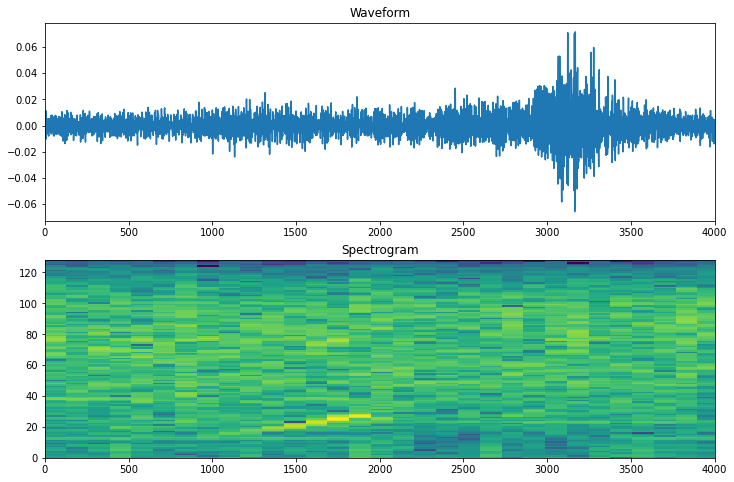

In [8]:
audio, label in waveform_ds.take(1)
fig, ax = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(audio.shape[0])
ax[0].plot(timescale, audio.numpy())
ax[0].set_title('Waveform')
ax[0].set_xlim([0, 4000])
functions.plot_spectrogram(spectrogram.numpy(), ax[1])
ax[1].set_xlim([0,4000])
ax[1].set_title('Spectrogram')
plt.show()

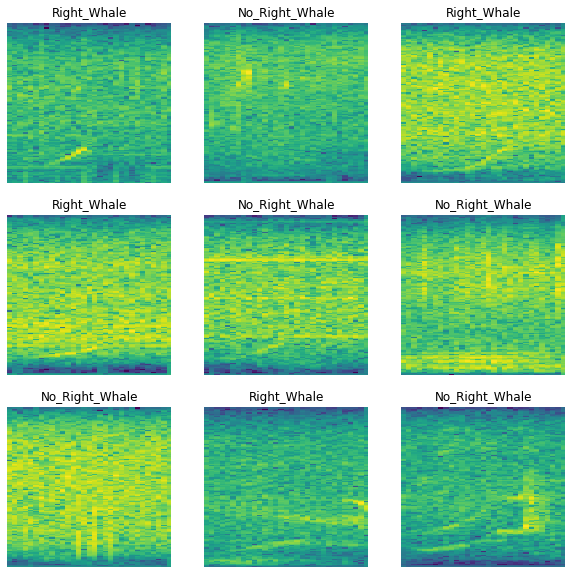

In [9]:
spectrogram, label_id = functions.get_spectrogram_and_label_id(audio, label)
spectrogram_ds = functions.create_spectrogram(train_files)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    functions.plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
    ax.set_title(labels[label_id.numpy()])
    ax.set_xlim([0,4000])
    ax.axis('off')

plt.show()

Even after converting the waveforms to spectrograms it is still not obvious of any indications that there is a right whale call in the sample

In [10]:
train_ds = spectrogram_ds
val_ds = functions.preprocess_dataset(val_files)
test_ds = functions.preprocess_dataset(test_files)
print('{} : Length of the Training Dataset'.format(len(train_ds)))

24000 : Length of the Training Dataset


In [11]:
print(train_ds)
print(val_ds)
print(test_ds)

<ParallelMapDataset shapes: ((None, 129, 1), ()), types: (tf.float32, tf.int64)>
<ParallelMapDataset shapes: ((None, 129, 1), ()), types: (tf.float32, tf.int64)>
<ParallelMapDataset shapes: ((None, 129, 1), ()), types: (tf.float32, tf.int64)>


In [12]:
batch_size = 32 
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
print('{} : Batched Length of the Training Dataset'.format(len(train_ds)))

750 : Batched Length of the Training Dataset


This NN design below was the original one except with an image size of (32, 32). To improve accuracy I increased image size which had an effect of increasing accuracy around 4%

Input shape: (124, 129, 1)
Number of Labels: 2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 96, 96, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 96, 96, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 94, 94, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 46, 46, 64)        0         
_________________________________________________________________
flatten (

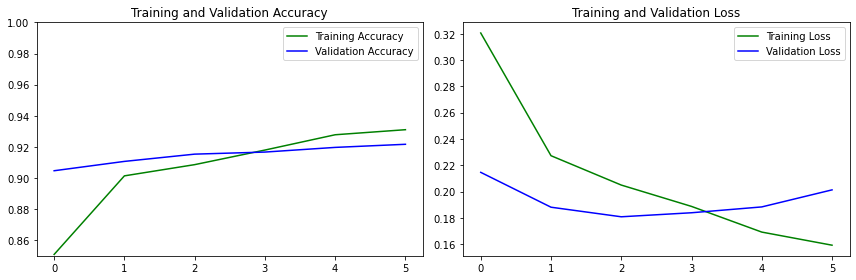

In [14]:
EPOCHS = 40
input_shape, norm_layer, num_labels = functions.NN_preprocessing(spectrogram_ds, labels)

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(96, 96), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],)

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS,
                    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),)

model.save("rps.h1")

functions.NN_graph('Accuracy', 'Loss', history, 'g', 'b')

As can be seen with the accuracy graphs the model is greatly overfitting. To try to solve this the NN was made deeper by adding another convolutional layer

Input shape: (124, 129, 1)
Number of Labels: 2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 96, 96, 1)         0         
_________________________________________________________________
normalization_1 (Normalizati (None, 96, 96, 1)         3         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 92, 92, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 44, 44, 128)       73856     
_________________________________________________________________
dropout

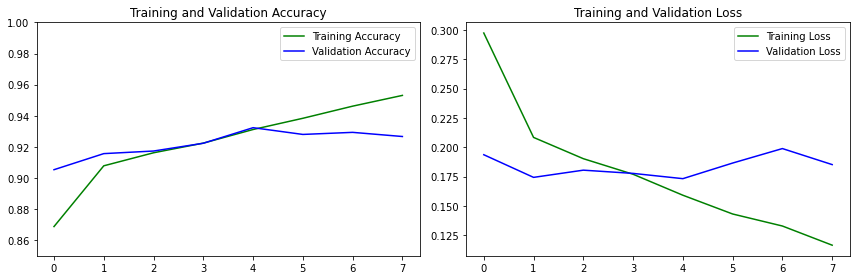

In [15]:
EPOCHS = 40
input_shape, norm_layer, num_labels = functions.NN_preprocessing(spectrogram_ds, labels)

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(96, 96), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],)

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS,
                    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),)

model.save("rps.h2")

functions.NN_graph('Accuracy', 'Loss', history, 'g', 'b')

The extra layer increased accuracy but it was still overfitting. To counteract this some regularisation was added.

Input shape: (124, 129, 1)
Number of Labels: 2
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 96, 96, 1)         0         
_________________________________________________________________
normalization_2 (Normalizati (None, 96, 96, 1)         3         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 92, 92, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 44, 44, 128)       73856     
_________________________________________________________________
dropout

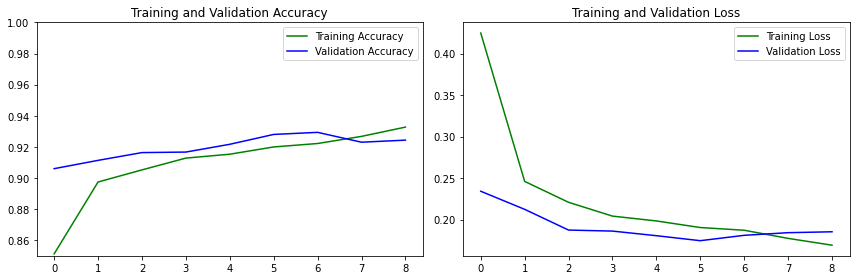

In [16]:
EPOCHS = 40
input_shape, norm_layer, num_labels = functions.NN_preprocessing(spectrogram_ds, labels)

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(96, 96), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', kernel_regularizer=regularizers.l2(l=0.01)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],)

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS,
                    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),)

model.save("rps.h3")

functions.NN_graph('Accuracy', 'Loss', history, 'g', 'b')

Then finally the learning rate was optimised as seen in the training loss graph, a different optimiser was used. The NN now doesn't overfit and the loss difference is minimal.

Input shape: (124, 129, 1)
Number of Labels: 2
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_4 (Resizing)        (None, 96, 96, 1)         0         
_________________________________________________________________
normalization_4 (Normalizati (None, 96, 96, 1)         3         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 94, 94, 32)        320       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 92, 92, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 44, 44, 128)       73856     
_________________________________________________________________
dropout

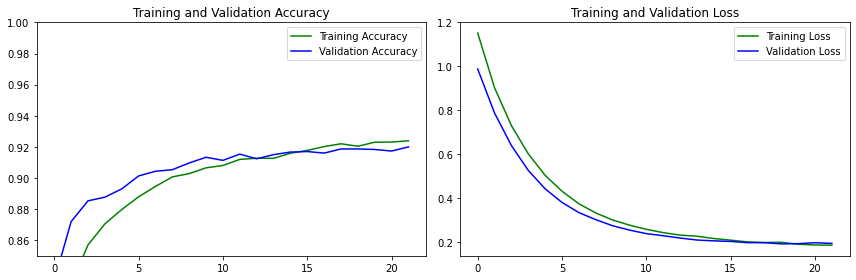

In [23]:
EPOCHS = 40
input_shape, norm_layer, num_labels = functions.NN_preprocessing(spectrogram_ds, labels)

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(96, 96), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', kernel_regularizer=regularizers.l2(l=0.01)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

sgd = tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],)

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS,
                    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),)

model.save("rps.h4")

functions.NN_graph('Accuracy', 'Loss', history, 'g', 'b')

This final network architecture isn't as accurate as previous setups but with the lower loss it should be a better model that can be further refined to increase accuracy.

In [18]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [20]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 92%


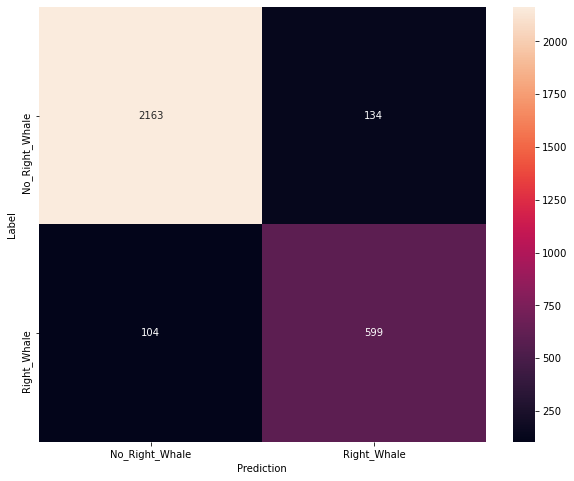

In [21]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=labels, yticklabels=labels, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()